In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
import numpy as np
import torch
from PIL import Image
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


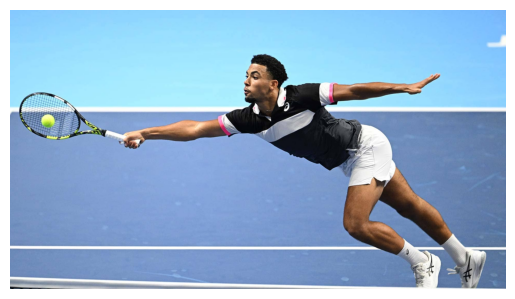

Caption for /content/tennis.jpg: a man swinging a tennis racquet at a ball 


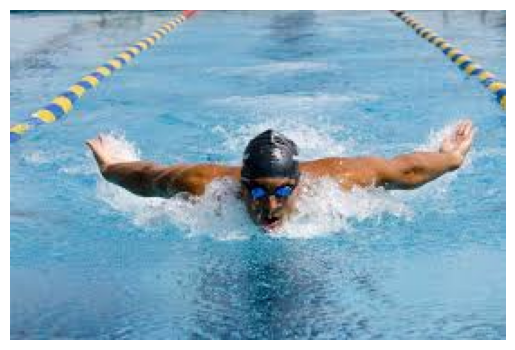


Image: /content/swimming.jpeg
Caption: a man is in the water on a blue and white swimming pool 


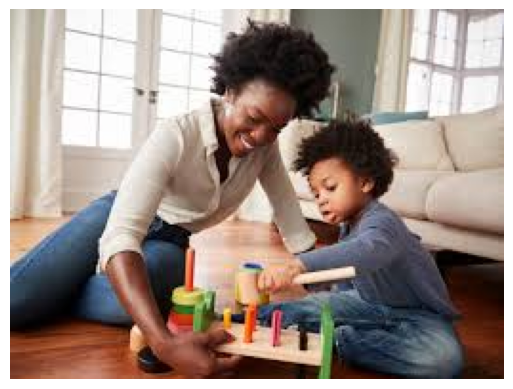


Image: /content/kidsplaying.jpeg
Caption: a boy and a girl are playing with a toy 


In [ ]:

class ImageCaptioner:
    def __init__(self):
        self.model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
        self.feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
        self.tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def generate_caption(self, image_path, max_length=30, num_beams=4):

        try:
            image = Image.open(image_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')

            pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
            pixel_values = pixel_values.to(self.device)
            output_ids = self.model.generate(
                pixel_values,
                num_beams=num_beams,
                max_length=max_length,
                no_repeat_ngram_size=2,
                num_return_sequences=1
            )

            caption = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
            return caption

        except Exception as e:
            return f"Error generating caption: {str(e)}"

    def process_batch(self, image_paths):

        results = {}
        for image_path in image_paths:
            caption = self.generate_caption(image_path)
            results[image_path] = caption
        return results

def main():

    captioner = ImageCaptioner()

    image_path = "/content/tennis.jpg"
    caption = captioner.generate_caption(image_path)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"Caption for {image_path}: {caption}")

    image_paths = [

        "/content/swimming.jpeg",
        "/content/kidsplaying.jpeg"

    ]
    results = captioner.process_batch(image_paths)

    for path, caption in results.items():
        img = mpimg.imread(path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print(f"\nImage: {path}")
        print(f"Caption: {caption}")

if __name__ == "__main__":
    main()